Pre-lab questions:

0a. How does the error scale with the sample number (N$_{sample}$) in monte carlo simulation

0b.  Random generate the time-tag APD data and show the code for calculating the g$^2$ on it. [IH] I think this requires some more background/working up to it

0c. What is expected value for g$^2$(0) for perfect single emitter measurement, two emitters measurement, N emitter measurement, respectively?

Pre-lab solutions:

0a. The error scale as 1/$\sqrt{N_{sample}}$

0b. g$^2$($\tau$) = $\frac{\langle I(t)I(t+\tau) \rangle}{\langle I(t) \rangle^2}$. For two given array, we can do a for loop for t and for loop for $\tau$ to gather the necessary informatin for g$^2$($\tau$) calculation.

0c. g$^2$(0)=1-1/N (N is the number of the single photon emitter).

1. Introduction
  Basic for Quantum Monte Carlo Simulation

Import the necessary library

In [ ]:
!pip install qutip
from qutip import *
import numpy as np
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 29.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


# HOM interference simulation

This lab module will focus on photon statistics from atomic systems. This will build towards a protocol to entangle two spin systems with high fidelity based on the Barrett-Kok protocol (Phys. Rev. A 71, 060310 (2005)).

## 1. Single atom decay

We will start off by looking at the statistics of photons from a emitter which has a spin-1/2 ground state: $|g_\downarrow\rangle$ & $|g_\uparrow\rangle$, and an optically excited state $|e\rangle$. We can represent these emitter states in QuTip with:

In [ ]:
Na = 3 # number of atomic levels
ground_down = basis(Na, 0)  # |g_down>
ground_up = basis(Na, 1)    # |g_up>
excited = basis(Na, 2)      # |e>

We would like to represent the coupling of the $|g_\downarrow\rangle_{s}\rightarrow|e\rangle_{s}$ transition with an EM field. We can assume this EM field is a cavity mode, with annihilation/creation operator $a/a^\dagger$. If the emitter interacts with the cavity with strength $g$, we can write the interaction Hamiltonian as:

$$\hat{H}/\hbar = g\left( \hat{a}\hat{\sigma}_{+}+\text{h.c.} \right)$$

In QuTip, this translates to

In [ ]:
N = 5 # Although Fock space fore cavity is infinite, we don't have infinite memory in our computer, so we simulate a maximum occupancy of 5 photons in the cavity
g0 = 2 # coupling strength (Rabi frequency of vacuum field)
a = tensor( destroy(N), qeye(Na) ) # annihiliation occurs of system A
# Here describes the interaction Hamiltonian
sigma = tensor(qeye(N), ground_down * excited.dag() ) # |g_down><e| of system A
H0_A = -g0 * ( sigma.dag()*a + a.dag()*sigma ) # time-independent Hamiltonian of system A

We next need to model the decay of the EM mode into the detector. This will be done using collapse operators that represent incoherent processes. In QuTip, this looks like:

In [ ]:
c_ops = [] # Build collapse operators
e_ops = tensor(qeye(N), qeye(Na) )

K_c = 10 # rate for collapsing to detector
K_e = 10 # environment
c_ops.append(np.sqrt(K_c) * a) # Collapsing to detector 1        c_ops[1]
c_ops.append(np.sqrt(K_c) * a) # Collapsing to environment       c_ops[2] -- i.e. photon collection efficiency is K_c/(K_e+K_c)

Finally, we can run the simulation. We will use the [quantum Monte-Carlo method](https://qutip.org/docs/latest/guide/dynamics/dynamics-monte.html) to solve the incoherent processes:

In [ ]:
# Define simulation parameters
numb = 1000 # numbers of trajectories
time_scale=200
tmax = 4.0 # (ns)
t = np.linspace(0.0, tmax, time_scale+1) # Define time vector (0 to 4ns, 20ps resolution)

# Define initial state
photon_initial_state = basis(N, 0) # Initial photonic ground state state
spin_initial_state = excited # Initial spin state
psi0 = tensor(photon_initial_state, spin_initial_state) # Initial global state

# Simulate
output = mcsolve(H0_A, psi0, t, c_ops, e_ops, ntraj = numb, progress_bar=True)


10.0%. Run time:   0.94s. Est. time left: 00:00:00:08
20.0%. Run time:   1.99s. Est. time left: 00:00:00:07
30.0%. Run time:   3.59s. Est. time left: 00:00:00:08
40.0%. Run time:   4.77s. Est. time left: 00:00:00:07
50.0%. Run time:   5.64s. Est. time left: 00:00:00:05
60.0%. Run time:   6.52s. Est. time left: 00:00:00:04
70.0%. Run time:   7.42s. Est. time left: 00:00:00:03
80.0%. Run time:   8.33s. Est. time left: 00:00:00:02
90.0%. Run time:   9.19s. Est. time left: 00:00:00:01
100.0%. Run time:  10.07s. Est. time left: 00:00:00:00
Total run time:  10.09s


## Questions

1a. Plot the APD counts over one trajectory based on the output result of the Quantum Monte Carlo simulation. Repeat for a random set of 10 trajectories.

Hint: output.col_which[x] returns a list of which collapses occured on the xth trajectory, and output.col_times gives the time of each those collapses.


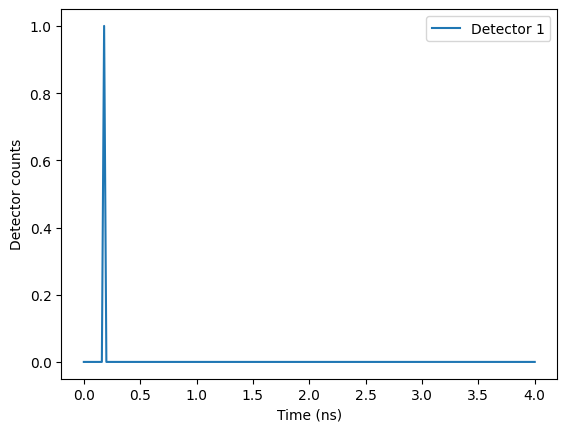

In [ ]:
# 1a ***solution***:

D1 = np.zeros(time_scale+1)
i0 = 7
index = len(output.col_which[i0])
for j in np.arange(index):
  if (output.col_which[i0][j] == 0):
    D1[int(output.col_times[i0][j]/0.02)] += 1

plt.plot(t,D1,label='Detector 1')
plt.legend(loc='upper right')
plt.ylabel('Detector counts')
plt.xlabel('Time (ns)')
plt.show()

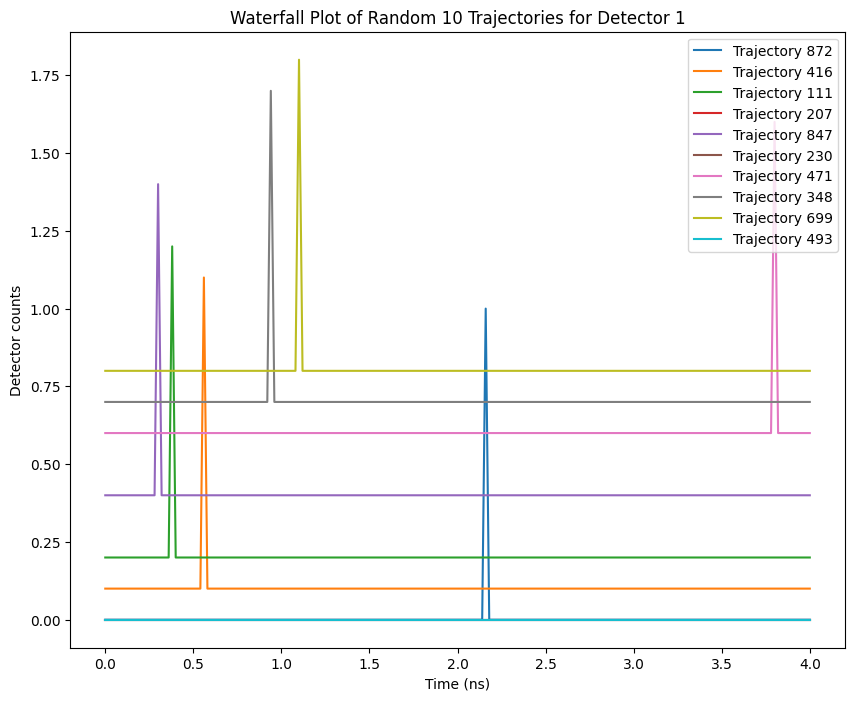

In [ ]:
time_scale = len(t) - 1
num_trajectories = len(output.col_which)  # Assuming this is how you'd get the total number of trajectories

# Select 10 random trajectories
#np.random.seed(42)  # For reproducibility, you can remove or change the seed
random_indices = np.random.choice(num_trajectories, size=10, replace=False)

# Initialize a figure
plt.figure(figsize=(10, 8))

# Plot for each randomly selected trajectory
for i, i0 in enumerate(random_indices):
    D1 = np.zeros(time_scale+1)
    index = len(output.col_which[i0])
    for j in np.arange(index):
        if (output.col_which[i0][j] == 0):
            D1[int(output.col_times[i0][j]/0.02)] += 1

    # Plot each trajectory with an offset or as a separate line
    offset = i * np.max(D1) * 0.1  # Adjust as needed
    plt.plot(t, D1 + offset, label=f'Trajectory {i0+1}')

plt.legend(loc='upper right')
plt.ylabel('Detector counts')
plt.xlabel('Time (ns)')
plt.title('Waterfall Plot of Random 10 Trajectories for Detector 1')
plt.show()


1b: Plot the cumulative APD counting when summing all the quantum Monte Carlo trajectories.

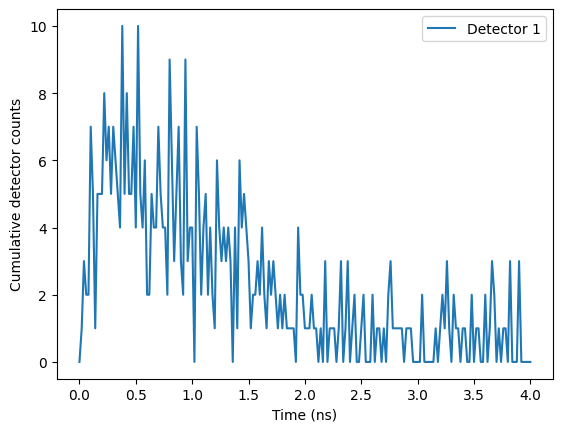

In [ ]:
# 1b ***solution***:

D1 = np.zeros(time_scale+1)

for i in np.arange(numb):
  index = len(output.col_which[i])
  for j in np.arange(index):
    if (output.col_which[i][j] == 0):
      D1[int(output.col_times[i][j]/0.02)] += 1


plt.plot(t,D1,label='Detector 1')
plt.legend(loc='upper right')
plt.ylabel('Cumulative detector counts')
plt.xlabel('Time (ns)')
plt.show()

1c Investigate the ratio of the variance of the number of photons detected over nblock=100, normalized by an equally bright coherent laser source (i.e., with the same mean photon number)

*1c* ***solution***
(1-p) where p=0.5

1d Re-run the above simulation with different values atom-cavity coupling, $g_0$, say 0.5, 1, and 2, and plot your results. Explain what you observe

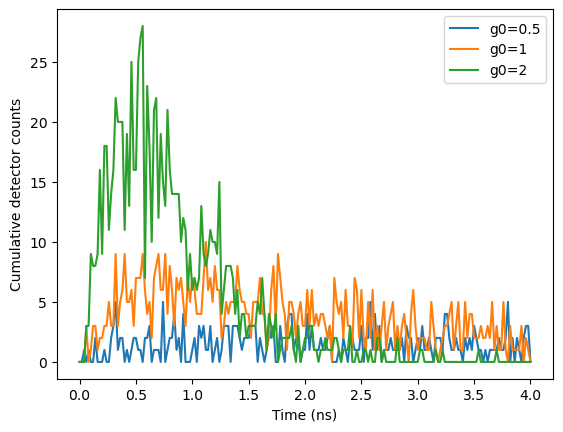

In [ ]:
# 1d ***solution***

gs = [.5, 1, 2]
Ds = []

numb = 1000 # numbers of trajectories

# Loop through g0 values

for g0 in gs:
    H0_A = g0 * ( sigma.dag()*a + a.dag()*sigma ) # time-independent Hamiltonian of system A

    # Simulate
    output = mcsolve(H0_A, psi0, t, c_ops, e_ops, ntraj = numb, progress_bar=False)

    D1 = np.zeros(time_scale+1)

    for i in np.arange(numb):
        index = len(output.col_which[i])
        for j in np.arange(index):
            if (output.col_which[i][j] == 0):
                D1[int(output.col_times[i][j]/0.02)] += 1

    Ds.append( D1 )

# Plot result
[plt.plot(t,x,label=f'g0={gs[i]}') for i, x in enumerate(Ds)]
plt.legend(loc='upper right')
plt.ylabel('Cumulative detector counts')
plt.xlabel('Time (ns)')
plt.show()

1e. We would next like to investigate the statistics of the photons being emitted by this system. One common way of doing this is by using an auto-correlation measurement where we measure a time delay between the single photon detection events while the atom is continuously excited. We can model the excitation with a semi-classical field of the form

$$ \Omega \big( \sigma + \sigma^\dagger \big) $$

Modify the single emitter code above to include the emitter driving using $g_0=2$ and $\Omega=.5$. For each Monte Carlo trajectory, count the the delay between every single photon event pair (incldue zero and negative delays) and show a histogra of the result. Explain why the histogram has the shape it does. How would this change if you had two driven emitters coupled to the cavity mode?

10.0%. Run time:  16.10s. Est. time left: 00:00:02:24
20.0%. Run time:  31.18s. Est. time left: 00:00:02:04
30.0%. Run time:  42.08s. Est. time left: 00:00:01:38
40.0%. Run time:  52.78s. Est. time left: 00:00:01:19
50.0%. Run time:  64.88s. Est. time left: 00:00:01:04
60.0%. Run time:  77.02s. Est. time left: 00:00:00:51
70.0%. Run time:  89.27s. Est. time left: 00:00:00:38
80.0%. Run time: 115.20s. Est. time left: 00:00:00:28
90.0%. Run time: 136.87s. Est. time left: 00:00:00:15
100.0%. Run time: 152.98s. Est. time left: 00:00:00:00
Total run time: 153.05s


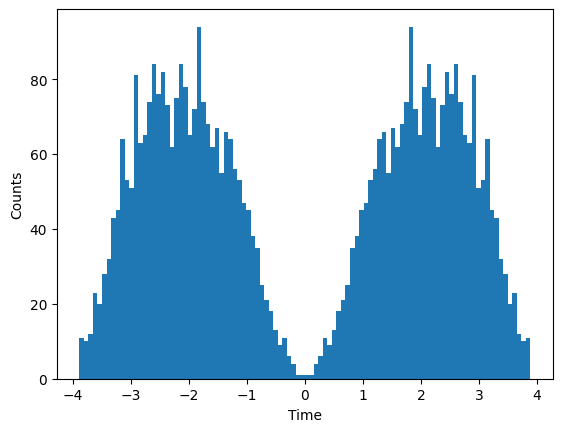

In [ ]:
# 1e ***solution***
psi0 = tensor( basis(N,0), excited )
numb = 5000

g1 = .5
HD = g1 * ( sigma.dag() + sigma ) # time-independent Hamiltonian of system A

output = mcsolve([H0_A, HD], psi0, t, c_ops, e_ops, ntraj = numb, progress_bar=True)

from itertools import permutations

g2 = []

for click_times in output.col_times:
  correlation = [ a - b for a, b in permutations(click_times, 2) ]
  g2.extend( correlation )


plt.hist( g2, 100 )
plt.ylabel('Counts')
plt.xlabel('Time')
plt.show()

## 2. Two-Emitter interference

We would now like to simulate what happens when we interfere the photons from two emitters, A & B, in a Hong-Ou-Mandel experiment shown schematically below:

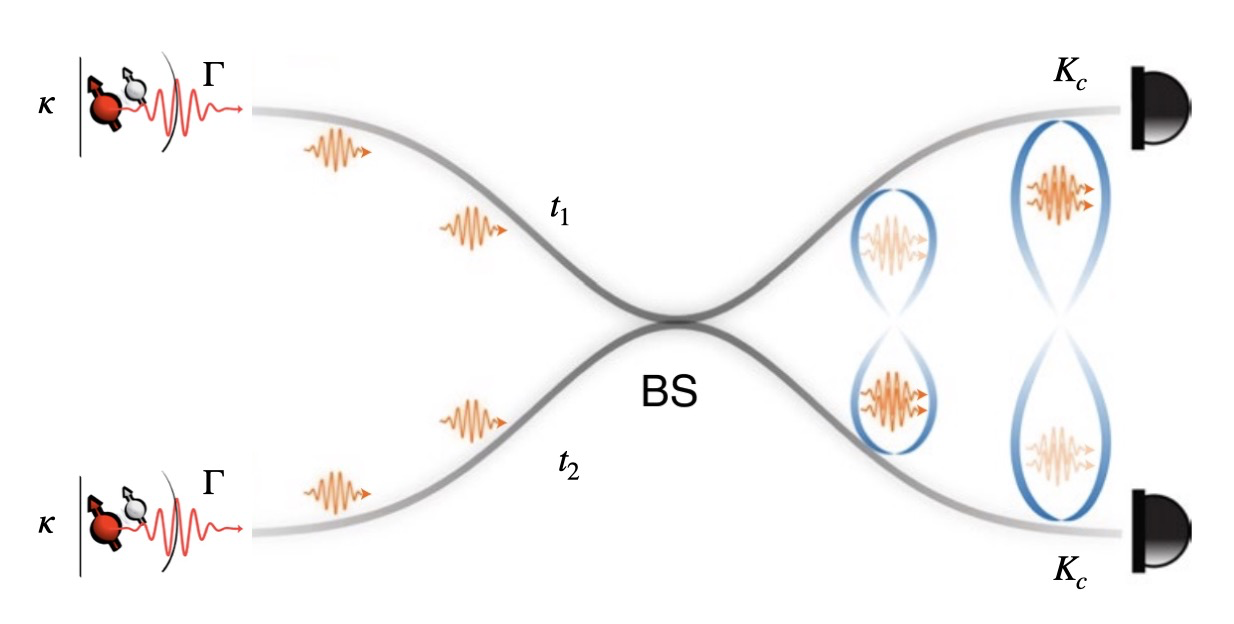

We would like simulate a more realistic setting, consisting of 3 steps:

**Step 1:** Prepare the initial state as the superposition state as: $|\psi_0\rangle=\frac{1}{\sqrt{2}}\left(|g_{\downarrow}0\rangle_A+|g_{\uparrow}0\rangle_A\right)\otimes\frac{1}{\sqrt{2}}\left(|g_{\downarrow}0\rangle_B+|g_{\uparrow}0\rangle_B\right)$.

**Step 2:** Excite the emitters with the time-dependent Hamiltonian that uses the semi-classical approximation: $$\hat{H}_{\text{exc}}\left(t\right)/\hbar=\sum_{s=A,B}P_s\left(t\right)\hat{\sigma}_{+,s}+\text{h.c.}$$
, where $P_s\left(t\right)$ is the Rabi frequency of the excitation pulse. For simplicity, let's assume identical Rabi frequencies, excitation pulses of system A and B as $\Omega$ and $P\left(t\right)$.

**Step 3:** Count the clicks that occur at detector $D_1$ or $D_2$, which are placed after a beam-splitter. Note that the beam-splitter mixes the A (B) photon modes, such that it measures $\hat{a}_A+\hat{a}_B$ (or $\hat{a}_A-\hat{a}_B$).

In the following, we provide the codes to simulate the HOM interferometer.

In [ ]:
# Here, let's choose the basis of state as |photon_A, spin_A, photon_B, spin_B>
N = 5 # Set where to truncate Fock state of cavity
sigma_A_gd_e = tensor(qeye(N), ground_down * excited.dag(), qeye(N), qeye(Na)) # |g_down><e| of system A
sigma_B_gd_e = tensor(qeye(N), qeye(Na), qeye(N), ground_down * excited.dag()) # |g_down><e| of system B
sigma_A_gd_gu = tensor(qeye(N), ground_down * ground_up.dag(), qeye(N), qeye(Na)) # |g_down><g_up| of system A
sigma_B_gd_gu = tensor(qeye(N), qeye(Na), qeye(N), ground_down * ground_up.dag()) # |g_down><g_up| of system B

In [ ]:
a_A = tensor(destroy(N), qeye(Na), qeye(N), qeye(Na)) # annihiliation operator of system A
a_B = tensor(qeye(N), qeye(Na), destroy(N), qeye(Na)) # annihiliation operator of system B
I = tensor(qeye(N), qeye(Na), qeye(N), qeye(Na)) # Unity operator

We would also like to include some more realistic loss processes, such as cavity loss and non-radiative decay. We can include these through some additional collapse operators

In [ ]:
c_ops = [] # Build collapse operators
e_ops = []
kappa =0.1 # Cavity decay rate
c_ops.append(np.sqrt(kappa) * a_A) # Cavity decay of system A. C0
c_ops.append(np.sqrt(kappa) * a_B) # Cavity decay of system B. C1

gamma =1 # Atomic decay rate
c_ops.append(np.sqrt(gamma) * sigma_A_gd_e) # spontaneous decay (decaying to modes other than cavity) from |e> to |g_down> of system A.   C2
c_ops.append(np.sqrt(gamma) * sigma_B_gd_e) # spontaneous decay (decaying to modes other than cavity) from |e> to |g_down> of system B.   C3

K_c = 10 # rate for collapsing to detector
c_ops.append(np.sqrt(K_c) * (a_A+a_B)/np.sqrt(2)) # Collapsing to detector 1        C4
c_ops.append(np.sqrt(K_c) * (a_A-a_B)/np.sqrt(2)) # Collapsing to detector 2        C5

In [ ]:
numb=1000 # numbers of trajectories
time_scale=200
tmax = 4.0 # (ns)
t = np.linspace(0.0, tmax, time_scale+1) # Define time vector (0 to 4ns, 20ps resolution)

# Step 1
theta=np.pi/4
photon = basis(N, 0) # Initial photonic state
spin = ground_down*np.cos(theta)+ground_up*np.sin(theta) # Initial spin state
psi0 = tensor(photon, spin, photon, spin) # Initial global state

g0 = 2 # coupling strength (Rabi frequency of vacuum field)
# Here describes the interaction Hamiltonian
H0_A = -g0 * (sigma_A_gd_e.dag() * a_A+a_A.dag()* sigma_A_gd_e) # time-independent Hamiltonian of system A
H0_B = -g0 * (sigma_B_gd_e.dag() * a_B+a_B.dag()* sigma_B_gd_e) # time-independent Hamiltonian of system B
H0 = H0_A + H0_B # time-independent Hermitian of global system

# Here describes the excitation Hamiltonian
H1_A = (sigma_A_gd_e.dag() + sigma_A_gd_e) # time-dependent Hamiltonian of system A after semi-classical approximation
H1_B = (sigma_B_gd_e.dag() + sigma_B_gd_e) # time-dependent Hamiltonian of system B after semi-classical approximation
e_ops.append(ket2dm(psi0).dag()* (ket2dm(psi0)))

# Excitation pulse parameters
center=0.5
life_time=0.04
peak =np.sqrt(np.pi)/2/life_time
excite_pulse_A = peak * np.exp(-((t-center) / life_time) ** 2)
excite_pulse_B = peak * np.exp(-((t-center) / life_time) ** 2)

#Step 2
H = [H0,[H1_A, excite_pulse_A],[H1_B, excite_pulse_B]]
output = mcsolve(H, psi0, t, c_ops, [], ntraj = numb, progress_bar=True)


10.0%. Run time:   5.16s. Est. time left: 00:00:00:46
20.0%. Run time:   5.73s. Est. time left: 00:00:00:22
30.0%. Run time:   6.31s. Est. time left: 00:00:00:14
40.0%. Run time:   6.94s. Est. time left: 00:00:00:10
50.0%. Run time:   7.50s. Est. time left: 00:00:00:07
60.0%. Run time:   8.10s. Est. time left: 00:00:00:05
70.0%. Run time:   8.68s. Est. time left: 00:00:00:03
80.0%. Run time:   9.26s. Est. time left: 00:00:00:02
90.0%. Run time:   9.81s. Est. time left: 00:00:00:01
100.0%. Run time:  10.39s. Est. time left: 00:00:00:00
Total run time:  10.45s


## Questions

2a: Adapt the code from before to get the cumulative counts in detectors 1 & 2

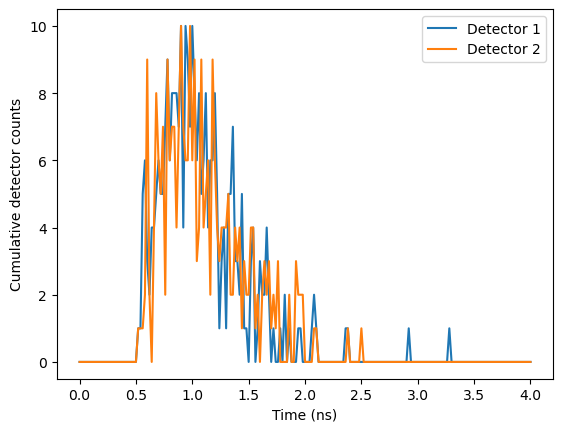

In [ ]:
# 2a ***solution***
D1 = np.zeros(time_scale+1)
D2 = np.zeros(time_scale+1)

for i in np.arange(numb):
  index = len(output.col_which[i])
  for j in np.arange(index):
    if (output.col_which[i][j] == 4):
      D1[int(output.col_times[i][j]/0.02)] += 1
    if (output.col_which[i][j] == 5):
      D2[int(output.col_times[i][j]/0.02)] += 1


plt.plot(t,D1,label='Detector 1')
plt.plot(t,D2,label='Detector 2')
plt.legend(loc='upper right')
plt.ylabel('Cumulative detector counts')
plt.xlabel('Time (ns)')
plt.show()

Let's take a look at the experimental HOM interefernce data from [Zhai, Liang, et al. "Quantum interference of identical photons from remote GaAs quantum dots." Nature Nanotechnology 17.8 (2022): 829-833.]((https://www.nature.com/articles/s41565-022-01131-2))

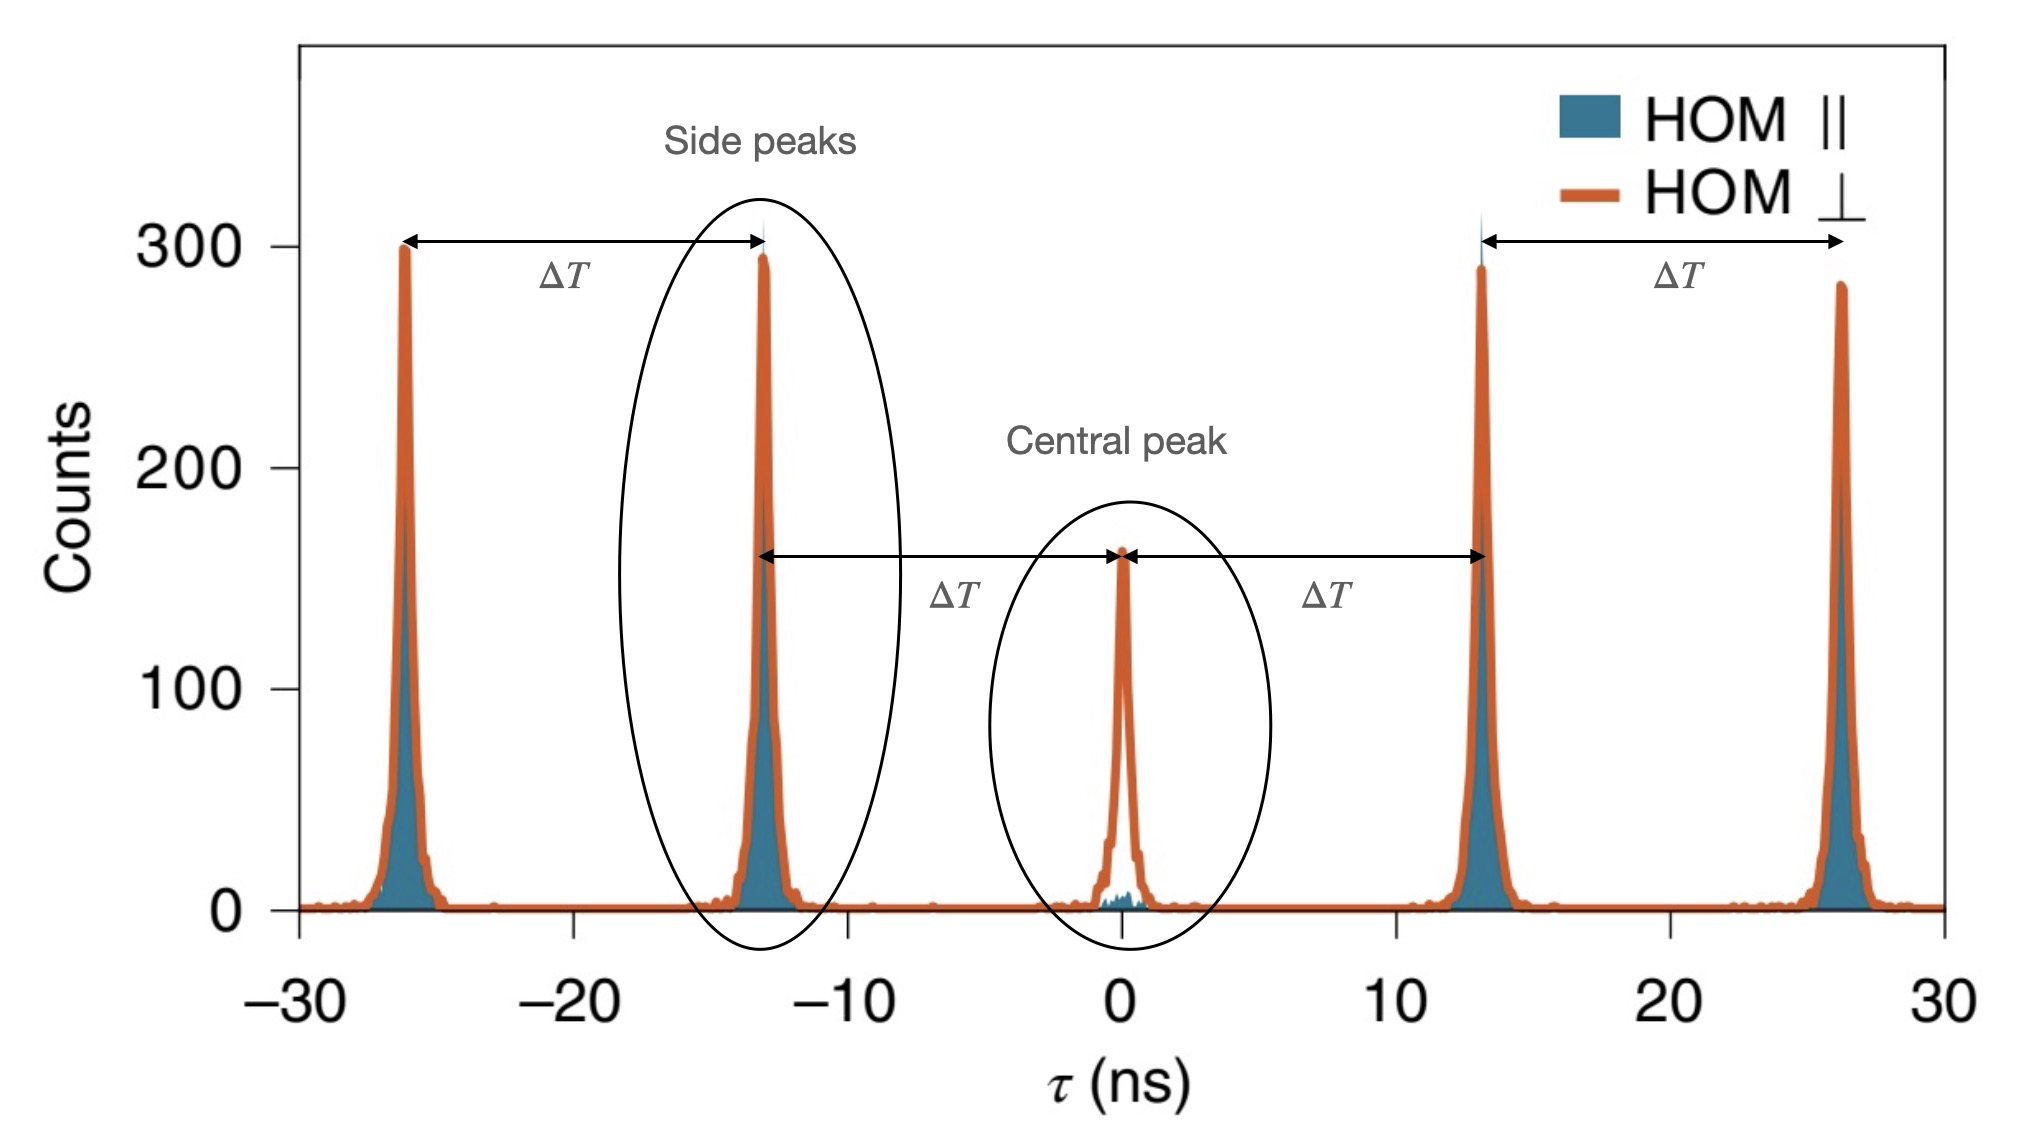

Here, Zhai et al. are repeatedely applying excitation pulses to two emitters A/B, and measuring the difference in time ($\tau$) between counts in detector D1/D2. This is called a correlation, or $g^2(\tau)$ measurement.

2b: Suppose you have an initial cavity mode state $\hat{a}_A\hat{a}_B|0\rangle$. Apply the beamsplitter transformation $\hat{a}_A \rightarrow \hat{a}_A+\hat{a}_B$ and $\hat{a}_B \rightarrow \hat{a}_A-\hat{a}_B$. What is the final state of the photon modes? If you were to detect these photons, what properties would they have? How does this relate to the HOM correlation at $\tau=0$?

Based on the quantum monte carlo simulation data, we can calculate the coincident event counting for the central peaks and side peaks. The code we use above is for the interference of two photons with the same polarization (HOM ||).

2c. Write the code for calculating the second order coincicent counting $g^2$($\tau$) for the central peak. Plot the result.

Text(0.5, 1.0, 'Central peak')

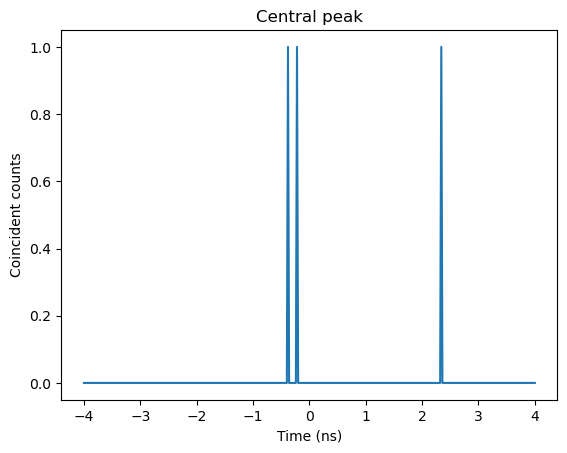

In [ ]:
counts = np.zeros(2*time_scale+1)
for i in np.arange(numb):
      D1 = np.zeros(time_scale+1)
      D2 = np.zeros(time_scale+1)
      for j in np.arange(len(output.col_which[i])):
        if (output.col_which[i][j] == 4):
          D1[int(output.col_times[i][j]/(tmax/time_scale))] += 1
        if (output.col_which[i][j] == 5):
          D2[int(output.col_times[i][j]/(tmax/time_scale))] += 1

      for j in np.arange(len(np.nonzero(D1)[0])):
          for k in np.arange(len(np.nonzero(D2)[0])):
              counts[1+time_scale+np.nonzero(D1)[0][j]-np.nonzero(D2)[0][k]] += 1

t2 = np.linspace(-tmax, tmax, 2*time_scale+1)
plt.plot(t2,counts)
plt.ylabel('Coincident counts')
plt.xlabel('Time (ns)')
plt.title('Central peak')

2d. Write the code for calculating the second order coincicent counting $g^2$($\tau$) for the side peak. Plot the result.

Hint: You can assume that neighbouring Monte Carlo trajectories come from different excitation pulses

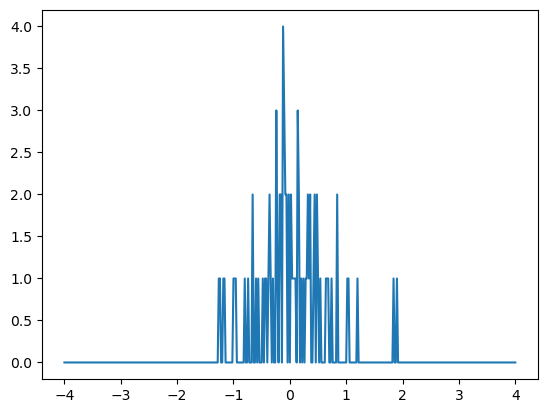

In [ ]:
counts2 = np.zeros(2*time_scale+1)
for i in np.arange(numb-1):
      D1 = np.zeros(time_scale+1)
      D3 = np.zeros(time_scale+1)
      for j in np.arange(len(output.col_which[i])):
        if (output.col_which[i][j] == 4):
          D1[int(output.col_times[i][j]/0.02)] += 1

      for j in np.arange(len(output.col_which[i+1])):
        if (output.col_which[i+1][j] == 5):
          D3[int(output.col_times[i+1][j]/0.02)] += 1

      for j in np.arange(len(np.nonzero(D1)[0])):
          for k in np.arange(len(np.nonzero(D3)[0])):
              counts2[1+time_scale+np.nonzero(D1)[0][j]-np.nonzero(D3)[0][k]] += 1

t2 = np.linspace(-4.0, 4.0, 2*time_scale+1)
plt.plot(t2,counts2)

2e: In the case of the perpendicular polarisation what should $g^2_{\perp}(0)$ be?

To quantify the quality of the photon interference, we can define the visibility:

$g^2_{||}$ = $I_{\text{central peak}}/I_{\text{side peak}}$ (For || case)

$g^2_{\perp}$ = $I_{\text{central peak}}/I_{\text{side peak}}$ (For $\perp$ case, which the result of 2a can be used)

$V=1-g^2_{||}/g^2_{\perp}$

2f: Calculate the visibility based on your result in 2b and 2c. Why isn't visibility 0?

Solution 3a.

In [ ]:
V = 1-(np.sum(counts)/np.sum(counts2))/0.5
print(V)

0.925


When applying time filtering window sample, it will change the counting integration window for both $I_{\text{central peak}}$ and $I_{\text{side peak}}$. Like the figure below.


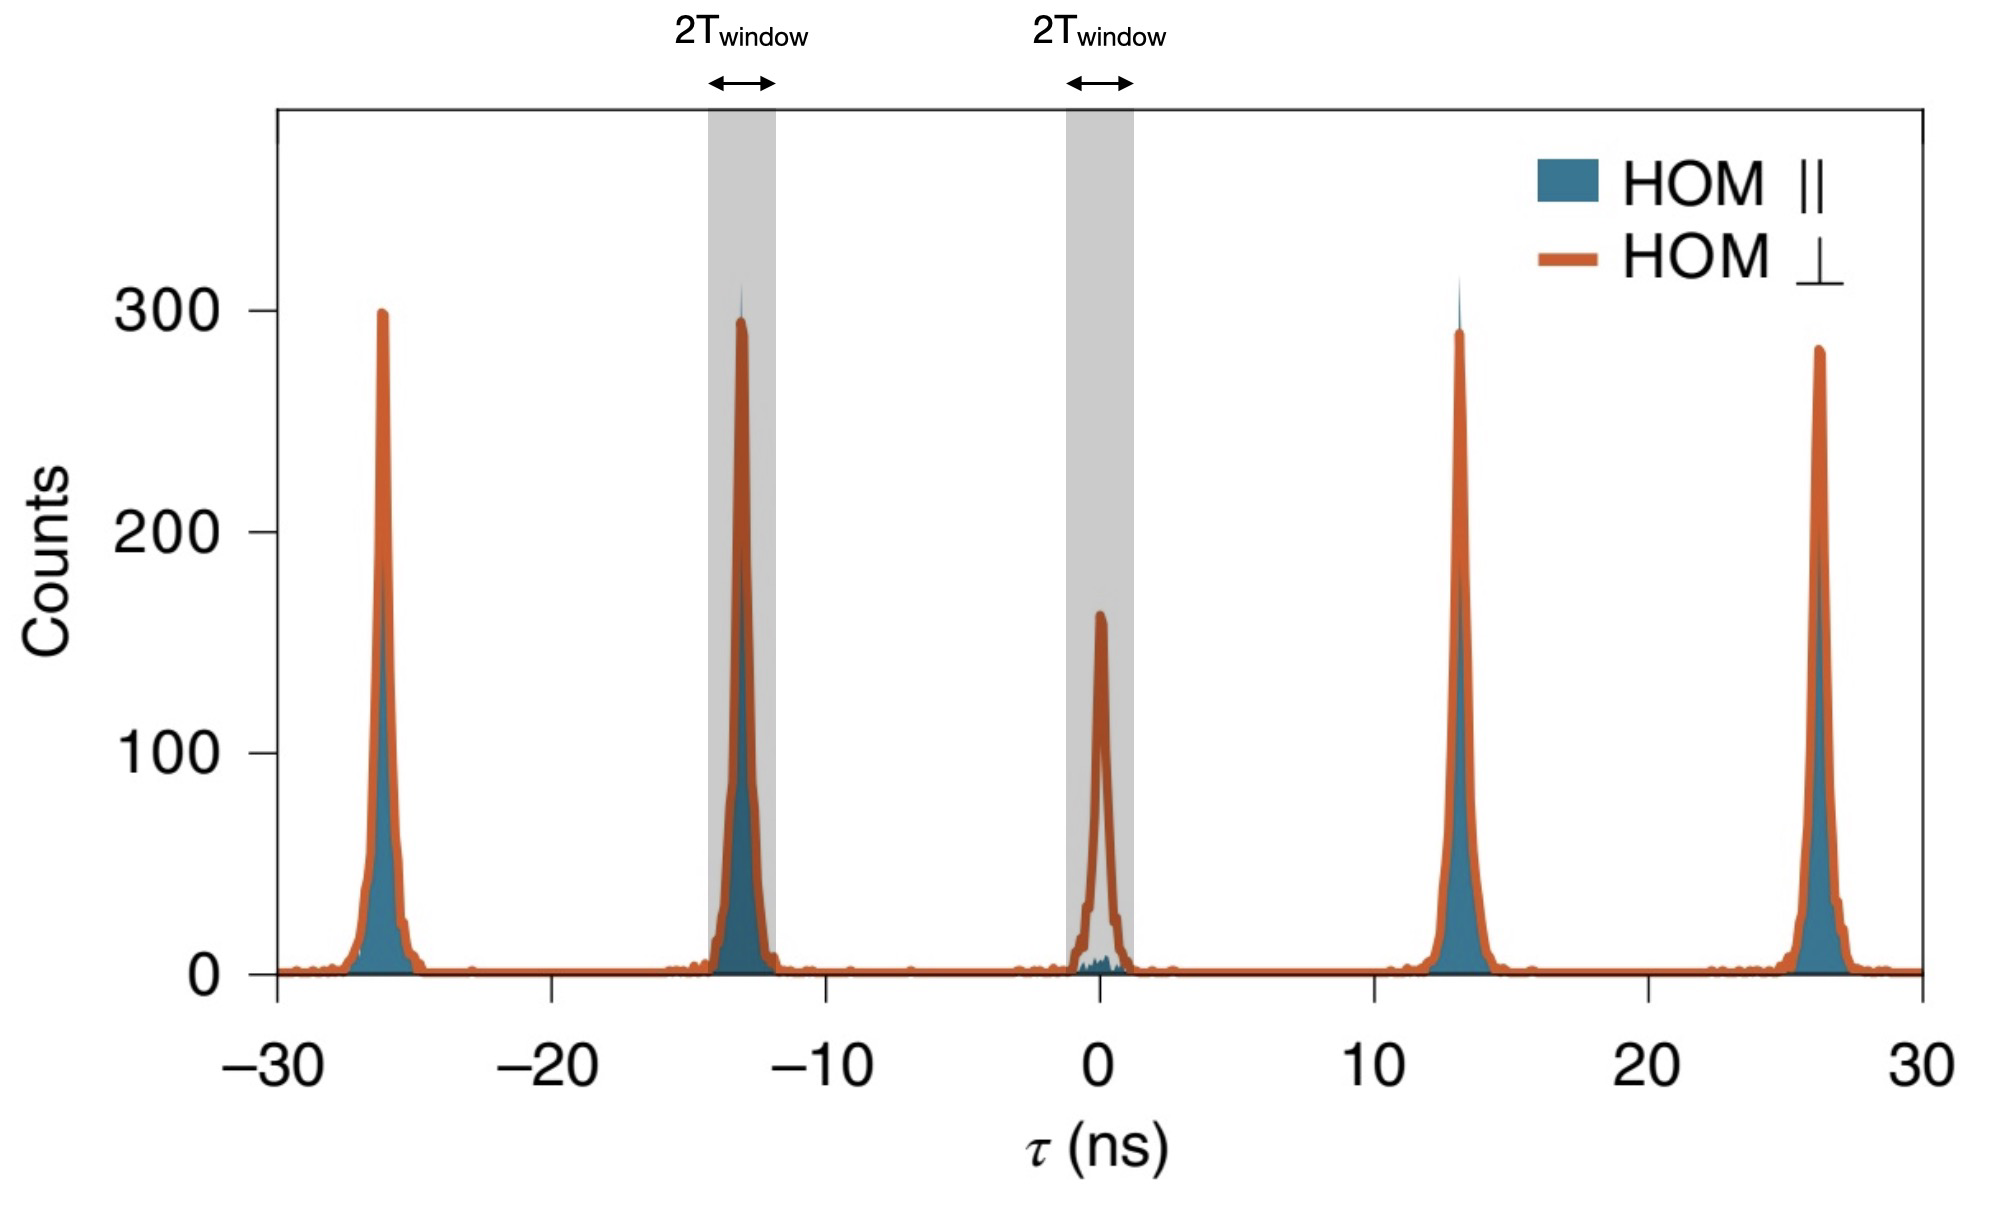

2g: Plot the relationship of the sampling window size and visibility.


Solution 2g. (A better numb will provide a better result)

c:\Users\Isaac\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Visibility')

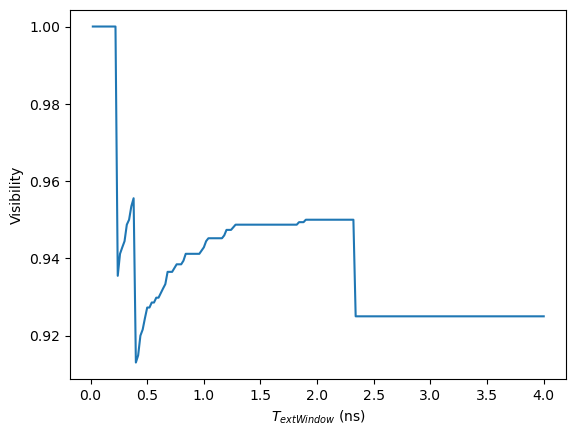

In [ ]:
V_window = np.zeros(time_scale+1)
for i in np.arange(time_scale+1):
  V_window[i] = 1-(np.sum(counts[time_scale+1-i:time_scale+1+i])/np.sum(counts2[time_scale+1-i:time_scale+1+i]))/0.5

plt.plot(t,V_window)
plt.xlabel('$T_{\text{Window}}$ (ns)')
plt.ylabel('Visibility')
plt.show()

## 3. Optional

3a. Modify the code to add the time delay $\Delta t$ of the arrival photon, calculate the coincident peaks for central peak and side peaks seperately. Provide the relation for the visibility and the  $\Delta t$.

Solution 3a.

In [ ]:
dt = 0
center=0.5
center2=0.5+dt # add extra offset in the excitation pulse

life_time=0.04
peak =np.sqrt(np.pi)/2/life_time
excite_pulse = peak * np.exp(-((t-center) / life_time) ** 2)
excite_pulse_new = peak * np.exp(-((t-center2) / life_time) ** 2)
# Update the interaction Hamiltonian with frequency detuning
H = [H0,[H1_A, excite_pulse],[H1_B, excite_pulse_new]]
output = mcsolve(H, psi0, t, c_ops, [], ntraj = numb, progress_bar=False)

Some dt sweep result is like this:

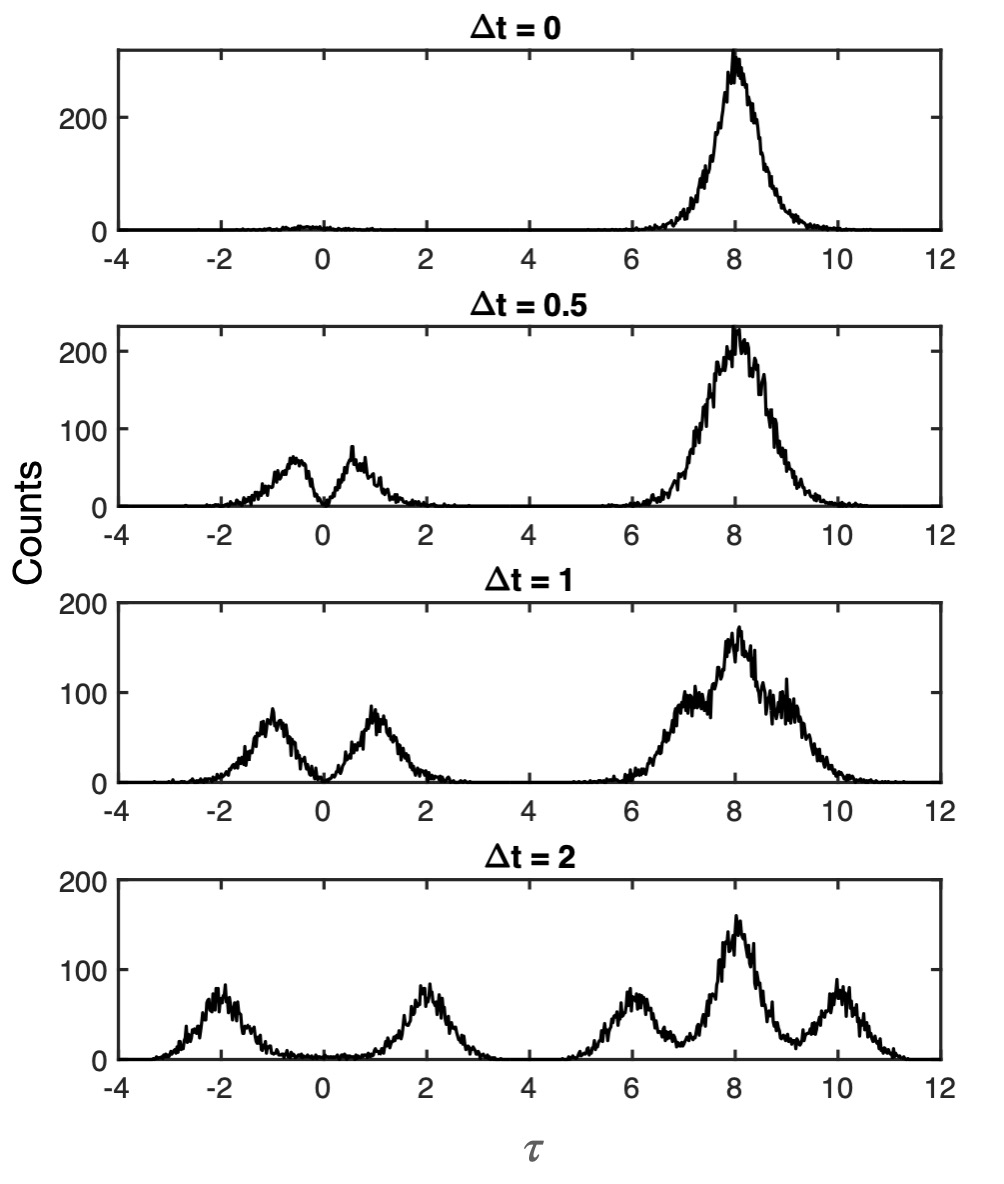

3b. (Optional) Modify the code to add the frequency detuning $\Delta f$ of the two quantum emitters system A and B, calculate the coincident peaks for central peak and side peaks seperately. Provide the relation for the visibility and the  $\Delta f$.

Hint: You only need to change the H0 to include the detuning term $\Delta f$ in the Hamiltonian。

Some example detuning from the reference [1] are attached below, which is the expected simulation result when have large enough frequency detuning.

[[1]](https://www.nature.com/articles/s41565-022-01131-2).  Zhai, Liang, et al. "Quantum interference of identical photons from remote GaAs quantum dots." Nature Nanotechnology 17.8 (2022): 829-833.

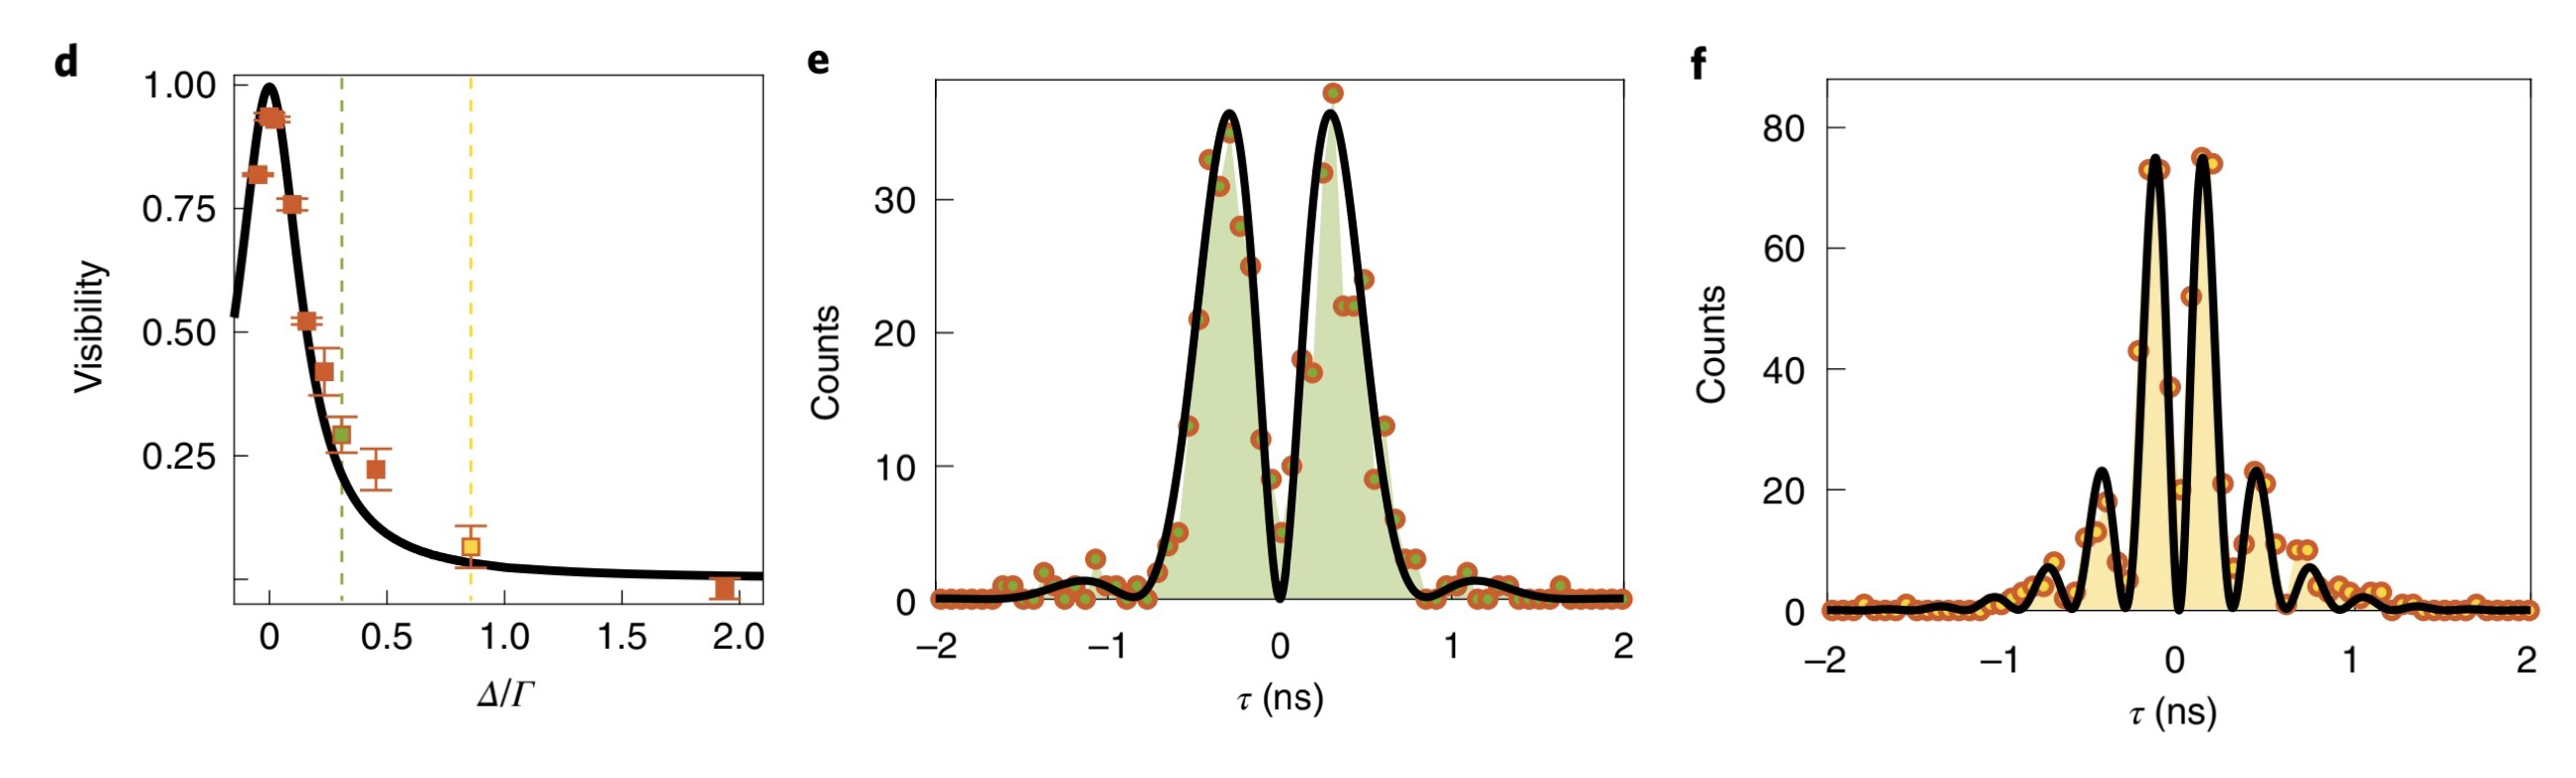

This is an example simulation that can be done with this QuTip simulation with different $\Delta f$.

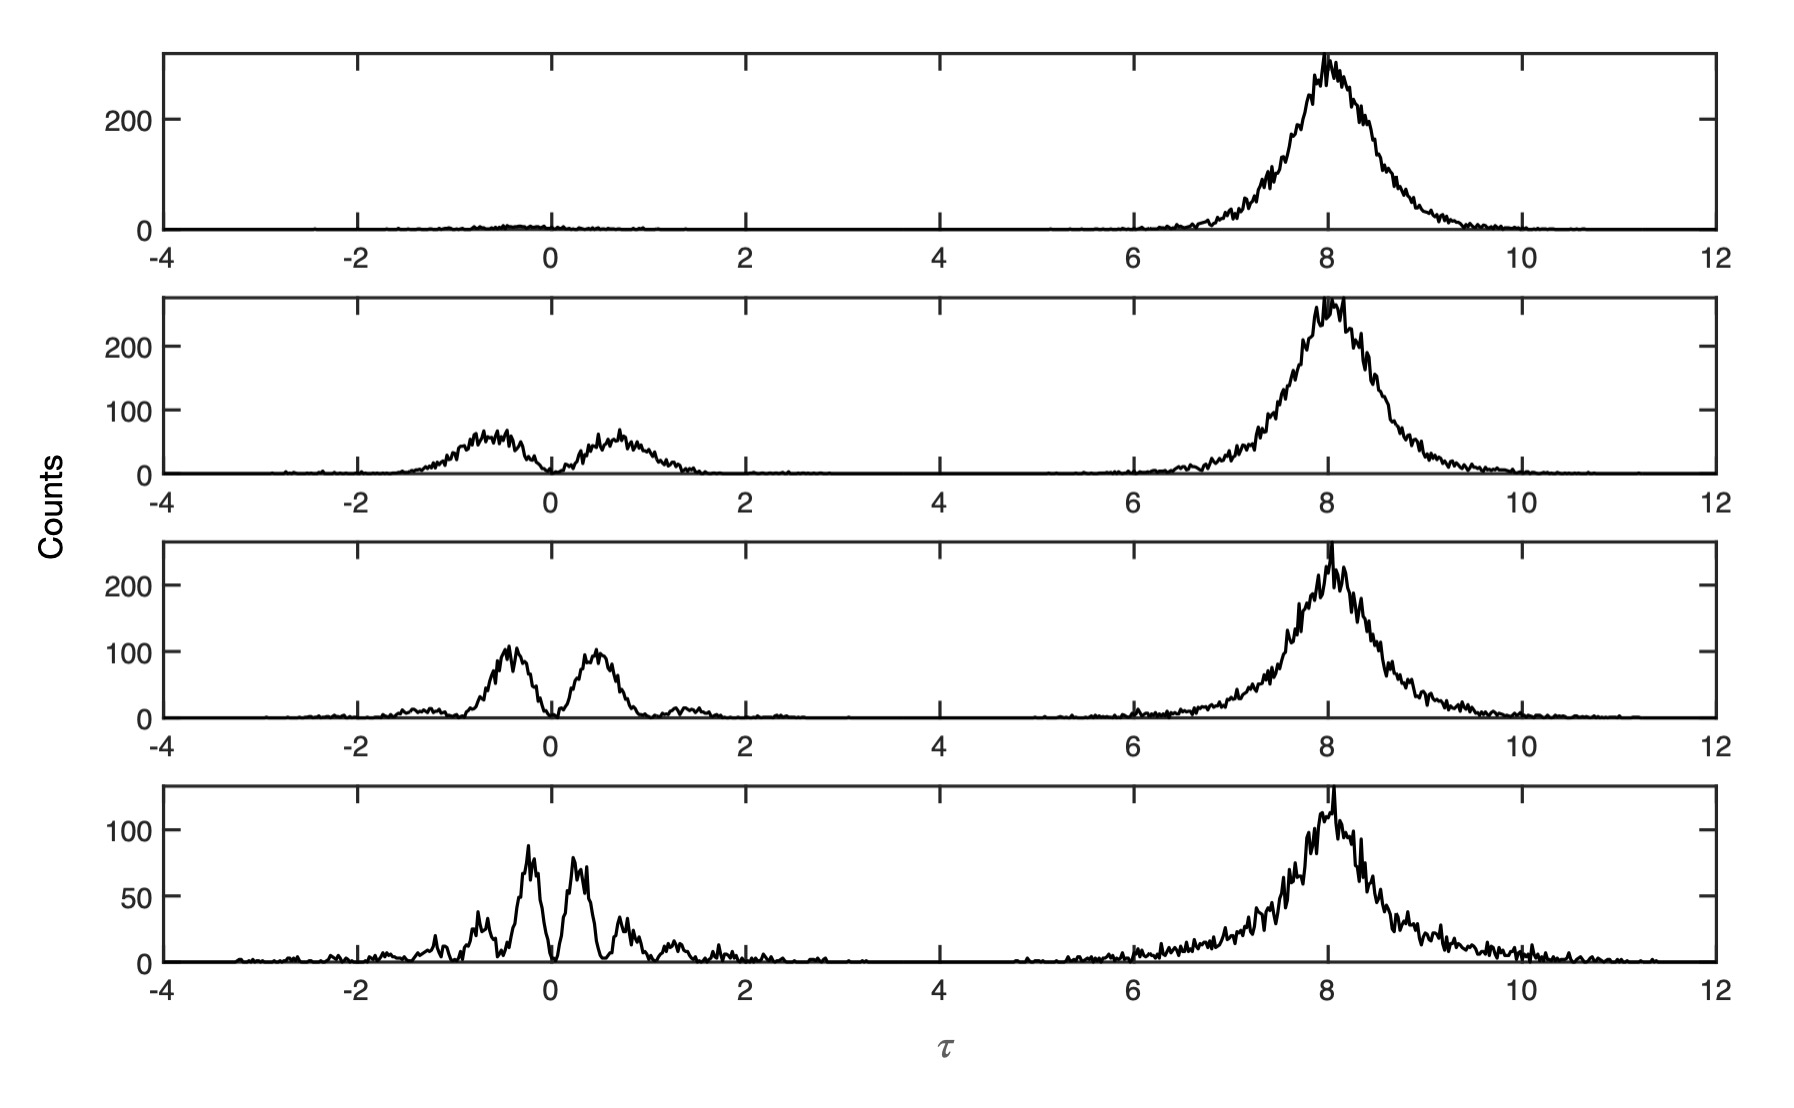

Solution 3b.

In [ ]:
df = 0
# Update the interaction Hamiltonian with frequency detuning
H0_A = -g0 * (sigma_A_gd_e.dag() * a_A+a_A.dag()* sigma_A_gd_e) - df/2 * (sigma_A_gd_e.dag()*sigma_A_gd_e)# time-independent Hamiltonian of system A
H0_B = -g0 * (sigma_B_gd_e.dag() * a_B+a_B.dag()* sigma_B_gd_e) + df/2 * (sigma_B_gd_e.dag()*sigma_B_gd_e)# time-independent Hamiltonian of system B
H0 = H0_A + H0_B # time-independent Hermitian of global system
H = [H0,[H1_A, excite_pulse],[H1_B, excite_pulse_new]]
output = mcsolve(H, psi0, t, c_ops, [], ntraj = numb, progress_bar=False)


Some df sweep result is like this

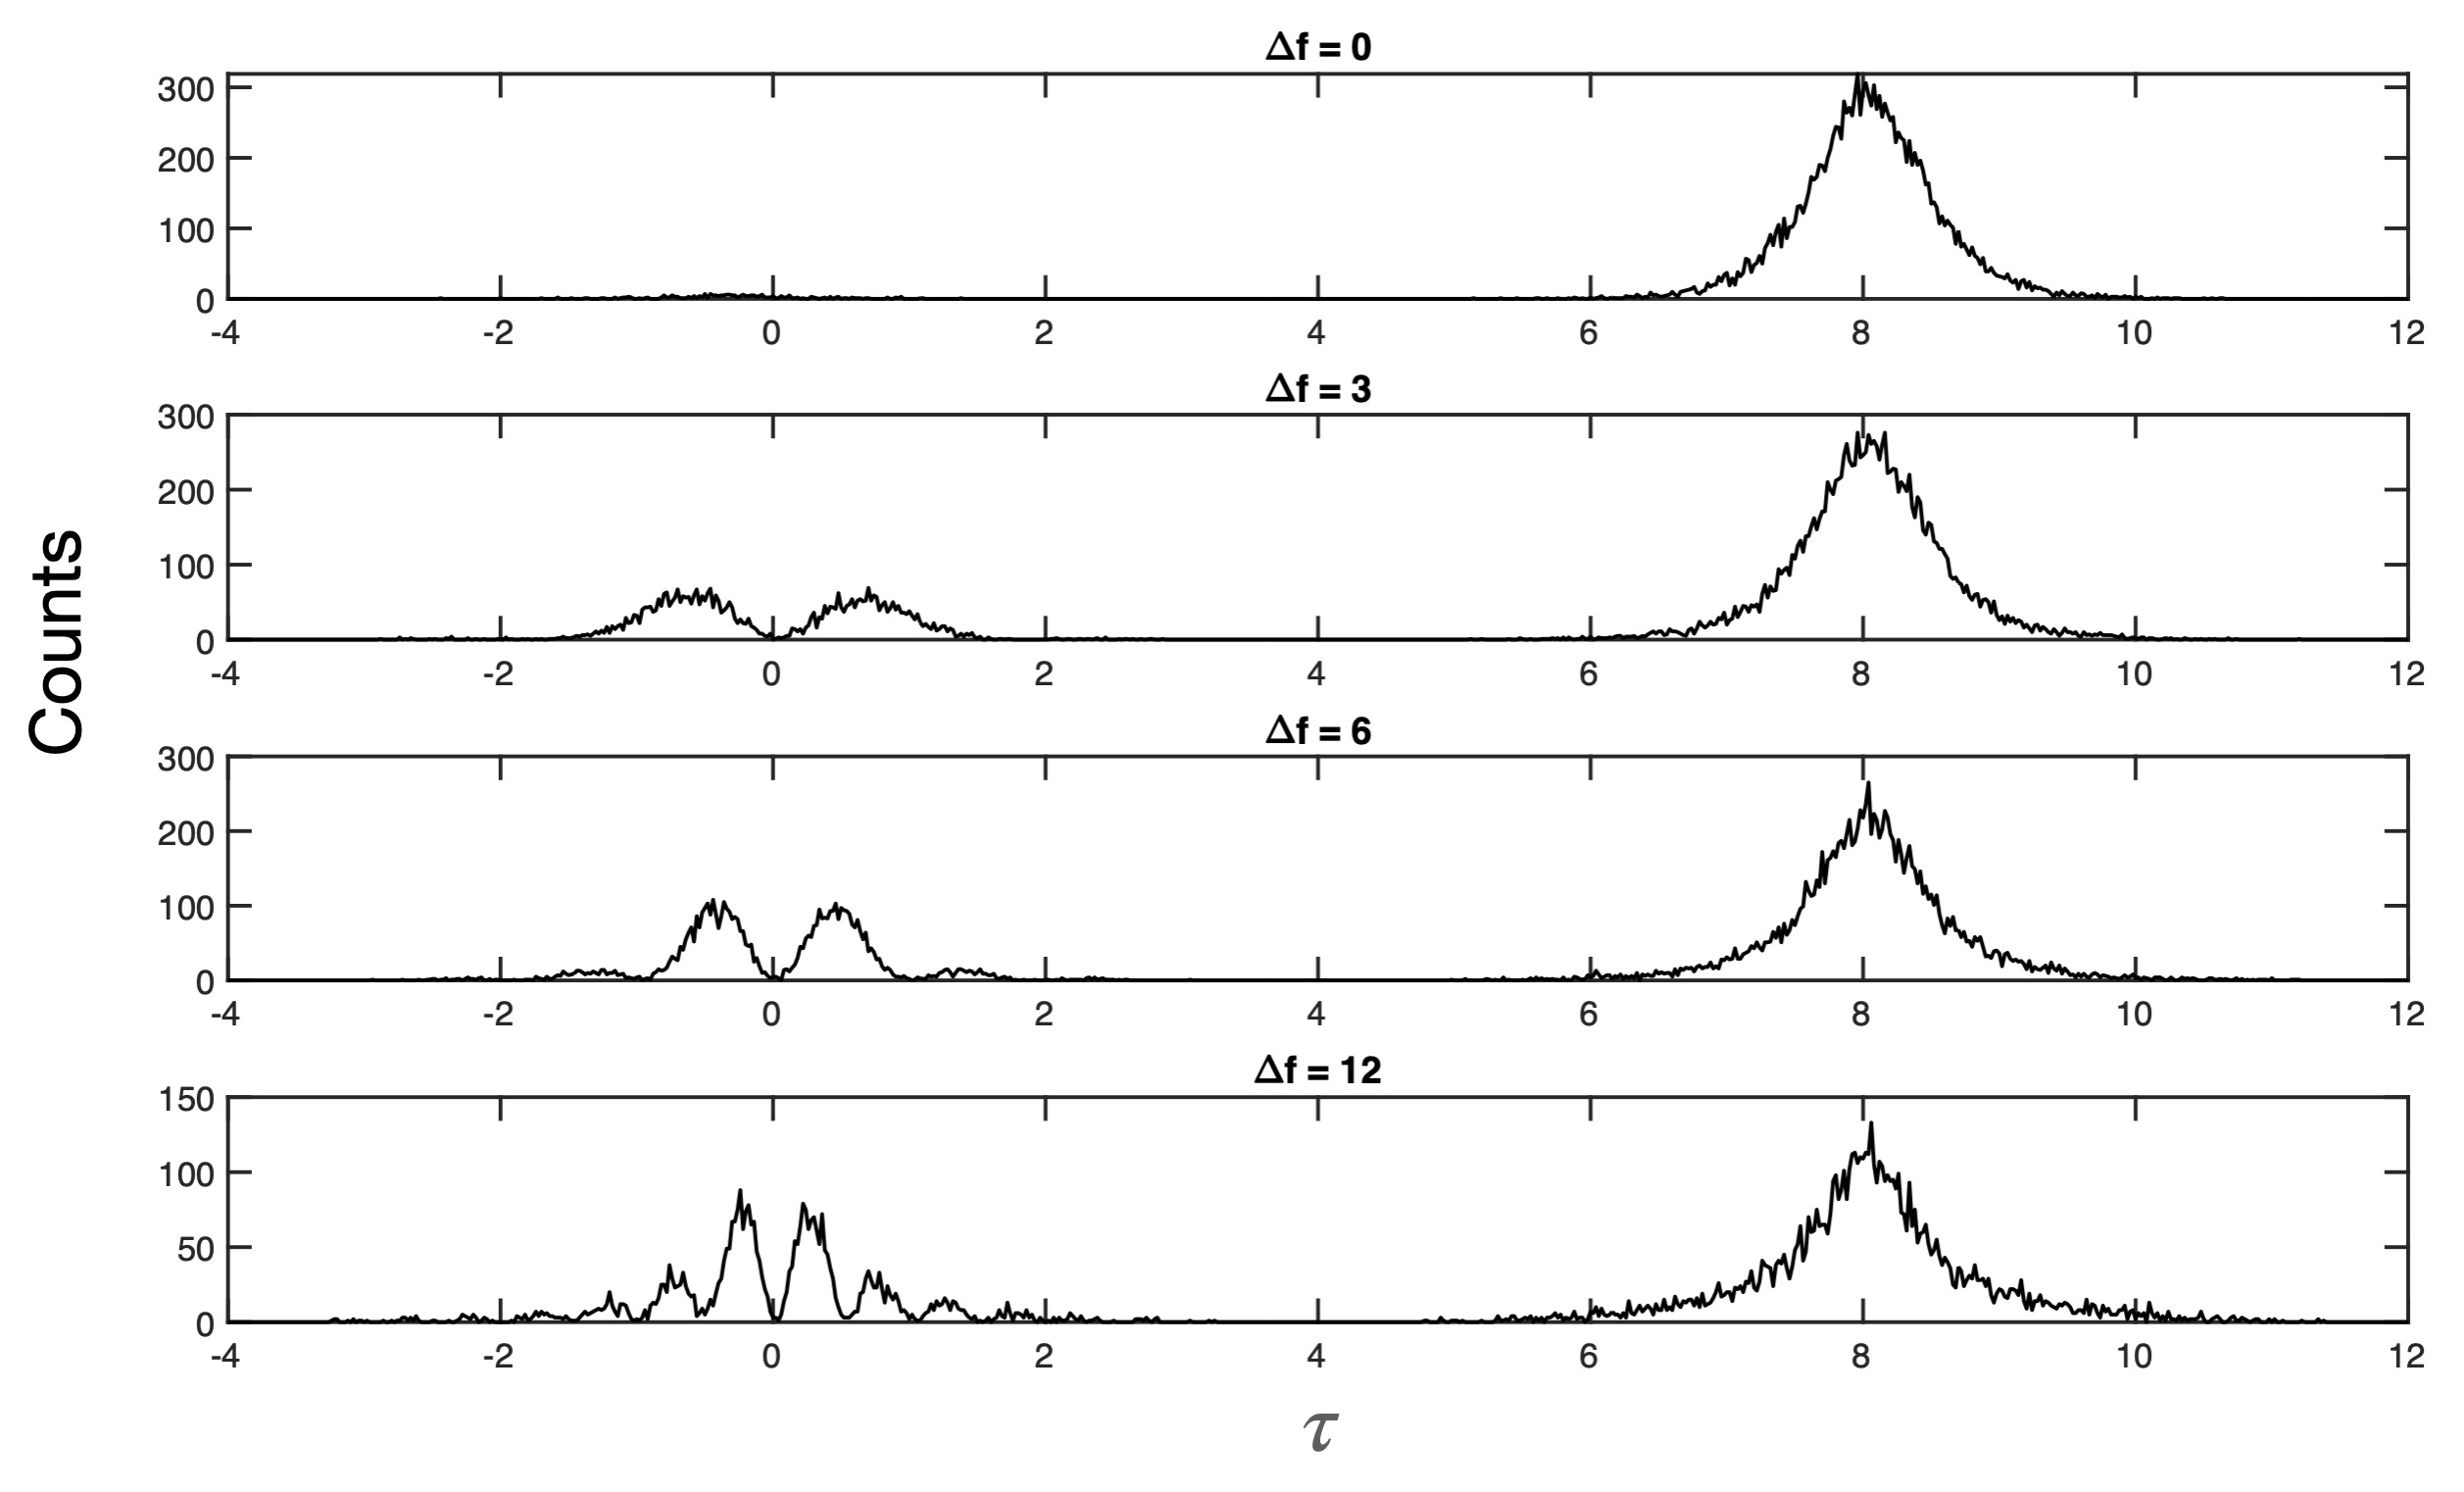

4c. (Open question) What other experimental effects can affect the HOM visibility? How to modify the code to simulate them?

* Extra reading:

From here, we know the importance of having the close photon arrival time and frequency alignment for the high visibility interference. The visibility will set a fidelity upper bound for the two quantum emitter entanglement. For the experimental hardware architecture that can realize the close arrival time and tunable quantum emitter frequency in a large scale, please read the following paper [2]:



[[2]](https://arxiv.org/abs/2308.14289). Li, Linsen, et al. "Heterogeneous integration of spin-photon interfaces with a scalable CMOS platform." 	arXiv:2308.14289. (2023)